In [139]:
%load_ext autoreload
%autoreload 2

import sys

import pandas as pd

import matplotlib.pyplot as plt

# get phospho data
ph_data = pd.read_pickle("./data/datasets/islets_PTP_dataset.pkl")
ph_sample_metadata = pd.read_pickle("./data/datasets/islets_PTP_sample_metadata.pkl")
ph_feature_metadata = pd.read_pickle("./data/datasets/islets_PTP_feature_metadata.pkl")

# parse position out of main identifier
ph_feature_metadata['aa_position'] = ph_feature_metadata.index.str.split('_').str[1]
ph_feature_metadata['position'] = ph_feature_metadata['aa_position'].replace('^.','',regex = True).astype(int)
ph_feature_metadata['uniprot_position'] = ph_feature_metadata['PG.UniProtIds'] + '_' + ph_feature_metadata['position'].astype(str)
ph_feature_metadata['Gene'] = ph_feature_metadata.index.str.split('_').str[0]

# functional annotation scores from [Ochoa, David, et al. "The functional landscape of the human phosphoproteome." Nature biotechnology 38.3 (2020): 365-373.]
fscores = pd.read_excel("./41587_2019_344_MOESM5_ESM.xlsx")
fscores['uniprot_position'] = fscores['uniprot'] + '_' + fscores['position'].astype(str)
fscores['GENE'] = fscores

# add functional scores to data
ph_feature_metadata = ph_feature_metadata.merge(fscores[['uniprot_position', 'functional_score']], on='uniprot_position', how='left')
ph_feature_metadata.set_index('PTM_collapse_key', inplace=True)

sys.path.append("src.py")
from src import Utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [F10] Phosphoproteomics 

Visualize phosphoproteomics differential results alongside functional score annotations


In [127]:
# ttest comparison between cell types (control only) for phospho data

ph_diff_exp = {}

# alpha vs. delta:
mask = ph_sample_metadata['sample'].isin(['alpha', 'delta'])
ph_diff_exp['alpha_over_delta'] = Utils.group_ratios_ttest_ind(ph_data[mask], ph_sample_metadata[mask], between = 'sample').join(ph_feature_metadata, how = 'left')

# beta vs. delta:
mask = ph_sample_metadata['sample'].isin(['beta', 'delta'])
ph_diff_exp['beta_over_delta'] = Utils.group_ratios_ttest_ind(ph_data[mask], ph_sample_metadata[mask], between = 'sample').join(ph_feature_metadata, how = 'left')

# alpha vs. beta:
mask = ph_sample_metadata['sample'].isin(['alpha', 'beta'])
ph_diff_exp['alpha_over_beta'] = Utils.group_ratios_ttest_ind(ph_data[mask], ph_sample_metadata[mask], between = 'sample').join(ph_feature_metadata, how = 'left')


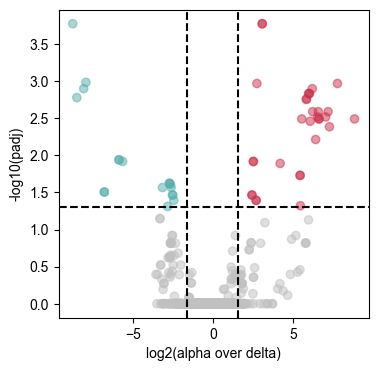

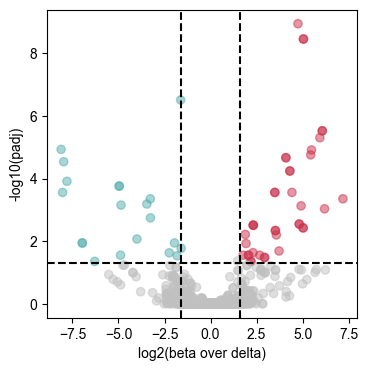

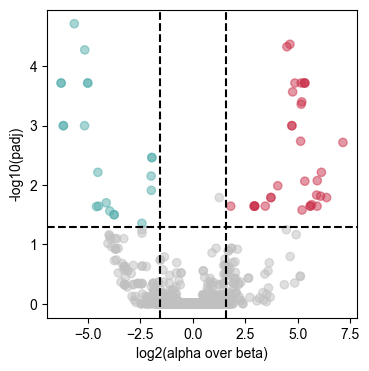

In [153]:
import numpy as np

# visualize and extract differentially regulated proteins
differentially_regulated_sites = {}
for comparison, diff_exp in ph_diff_exp.items():

    P_LIM = 0.05
    X_LIM = 3

    x_col = f'delta_{comparison}'
    y_col = f'padj_{comparison}'

    diff_exp[f'neg_log10_{y_col}'] = -np.log10(diff_exp[y_col])

    diff_exp['regulated'] = 'not regulated'
    diff_exp.loc[((diff_exp[x_col] > np.log2(X_LIM)) & (diff_exp[y_col] < P_LIM)), 'regulated'] = 'upregulated'
    diff_exp.loc[((diff_exp[x_col] < -np.log2(X_LIM)) & (diff_exp[y_col] < P_LIM)), 'regulated'] = 'downregulated'

    colormap = {
        'not regulated': '#C0C0C0',
        'upregulated': '#cb334d',
        'downregulated': '#54aead',
        'selected' : '#3a7eb8',
    }

    differentially_regulated_sites[comparison] = diff_exp[diff_exp['regulated'].isin(['upregulated', 'downregulated'])].copy()

    # plot volcano plot
    fig, ax = plt.subplots(figsize=(4, 4))

    reg_colors = diff_exp['regulated'].map(colormap)
    ax.scatter(diff_exp[x_col], diff_exp[f'neg_log10_{y_col}'], c=reg_colors, alpha=0.5)
    
    ax.axhline(y=-np.log10(P_LIM), color='black', linestyle='--')
    ax.axvline(x=np.log2(X_LIM), color='black', linestyle='--')
    ax.axvline(x=-np.log2(X_LIM), color='black', linestyle='--')

    ax.set_xlabel(f'log2({" ".join(comparison.split("_"))})')
    ax.set_ylabel('-log10(padj)')

In [154]:
# find orthologs
for comparison, diff_exp in differentially_regulated_sites.items():
    print(diff_exp['PG.UniProtIds'].unique())

['O35085' 'P16014' 'Q7TS73' 'Q9D1Y9' 'Q5SWY7' 'P55095' 'Q99MA9' 'P60041']
['Q8K0M7' 'Q9CQV4' 'Q5SWY7' 'Q8C419' 'B2RXC2' 'P57016' 'Q8CF90' 'Q99MA9'
 'P97926' 'P48437' 'P35822' 'Q9EPS2' 'Q80U57' 'Q8VCX2' 'Q04692' 'Q9JJY3'
 'P60041' 'Q9WUH1' 'Q01320']
['O35085' 'P55095' 'Q9DAS9' 'Q8C419' 'B2RXC2' 'P57016' 'A2AQW0' 'Q9CQ20'
 'Q99MA9' 'P97926' 'E9PZ87' 'P63239' 'P35822' 'Q80U57' 'P14246']


In [158]:
# ortholog mapping since this dataset is from M.musculus

from Bio import pairwise2
from Bio.Seq import Seq
from Bio import SeqIO
from biomart import BiomartServer


# get this mapping from the ENSEMBL databaset:
# http://www.ensembl.org/biomart/martview/775974b699d308980b35a596a385b751?VIRTUALSCHEMANAME=default&ATTRIBUTES=mmusculus_gene_ensembl.default.homologs.ensembl_gene_id|mmusculus_gene_ensembl.default.homologs.ensembl_gene_id_version|mmusculus_gene_ensembl.default.homologs.ensembl_transcript_id|mmusculus_gene_ensembl.default.homologs.ensembl_transcript_id_version|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_ensembl_gene|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_associated_gene_name|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_perc_id|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_ensembl_peptide|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_orthology_type|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_orthology_confidence|mmusculus_gene_ensembl.default.homologs.external_gene_name&FILTERS=&VISIBLEPANEL=resultspanel

#read mapping
pd.read_csv("./mouse2human_ortholog_mapping.txt", header = 0).dropna(subset=["Human gene name"])

# try mapping the mouse UniProt IDs to human

# load human uniprot IDs and fasta

# load mouse uniprot IDs and fasta

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Human gene stable ID,Human gene name,%id. target Human gene identical to query gene,Human protein or transcript stable ID,Human homology type,"Human orthology confidence [0 low, 1 high]",Gene name
5,ENSMUSG00000064341,ENSMUSG00000064341.1,ENSMUST00000082392,ENSMUST00000082392.1,ENSG00000198888,MT-ND1,77.0440,ENSP00000354687,ortholog_one2one,1.0,mt-Nd1
9,ENSMUSG00000064345,ENSMUSG00000064345.1,ENSMUST00000082396,ENSMUST00000082396.1,ENSG00000198763,MT-ND2,57.3913,ENSP00000355046,ortholog_one2one,1.0,mt-Nd2
15,ENSMUSG00000064351,ENSMUSG00000064351.1,ENSMUST00000082402,ENSMUST00000082402.1,ENSG00000198804,MT-CO1,90.6615,ENSP00000354499,ortholog_one2one,1.0,mt-Co1
18,ENSMUSG00000064354,ENSMUSG00000064354.1,ENSMUST00000082405,ENSMUST00000082405.1,ENSG00000198712,MT-CO2,71.3656,ENSP00000354876,ortholog_one2one,1.0,mt-Co2
20,ENSMUSG00000064356,ENSMUSG00000064356.1,ENSMUST00000082407,ENSMUST00000082407.1,ENSG00000228253,MT-ATP8,46.2687,ENSP00000355265,ortholog_one2one,0.0,mt-Atp8
...,...,...,...,...,...,...,...,...,...,...,...
285960,ENSMUSG00000048550,ENSMUSG00000048550.18,ENSMUST00000054591,ENSMUST00000054591.10,ENSG00000185875,THNSL1,82.1954,ENSP00000365534,ortholog_one2one,1.0,Thnsl1
285961,ENSMUSG00000048550,ENSMUSG00000048550.18,ENSMUST00000102952,ENSMUST00000102952.8,ENSG00000185875,THNSL1,82.1954,ENSP00000365534,ortholog_one2one,1.0,Thnsl1
285962,ENSMUSG00000048550,ENSMUSG00000048550.18,ENSMUST00000138965,ENSMUST00000138965.8,ENSG00000185875,THNSL1,82.1954,ENSP00000365534,ortholog_one2one,1.0,Thnsl1
285963,ENSMUSG00000048550,ENSMUSG00000048550.18,ENSMUST00000138914,ENSMUST00000138914.8,ENSG00000185875,THNSL1,82.1954,ENSP00000365534,ortholog_one2one,1.0,Thnsl1
